In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_dir = os.path.join(dirname, filename)

# system package(warnings message)
import warnings
warnings.filterwarnings('ignore')

# Wrangling package
import pandas as pd
import numpy as np

# EDA package
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modeling package
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

## Load the Data

In [2]:
data = pd.read_csv(file_dir)

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
data.drop('customerID', axis = 1, inplace = True)

We dont't need column 'customerID', so drop that column.

In [6]:
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

There is no NaN value.

In [7]:
obj_cols = data.columns[data.dtypes == object] # object dtype columns
num_cols = data.columns[data.dtypes != object] # numeric dtype columns

In [8]:
obj_cols.tolist()

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges',
 'Churn']

There are 17 object columns. But 'Churn' column is target variable(binary) and 'TotalCharges' column is numeric column.

In [9]:
num_cols.tolist()

['SeniorCitizen', 'tenure', 'MonthlyCharges']

There are 3 numeric columns. When including 'TotalCharges', there are 4.

In [10]:
data.Churn = data.Churn.map({'Yes' : 1, 'No' : 0})

We made 'Churn' binary values(0 or 1).

***

## EDA

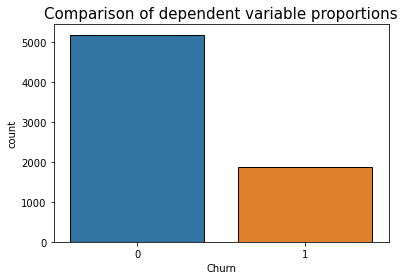

In [11]:
plt.title('Comparison of dependent variable proportions', size = 15)
sns.countplot(data.Churn, edgecolor = (0,0,0))
plt.show()

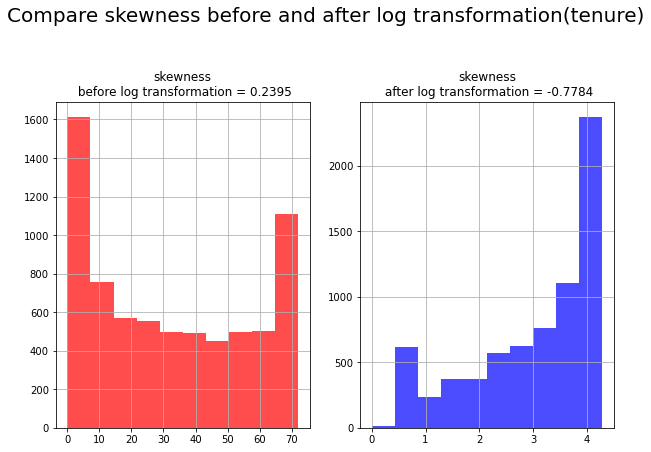

In [12]:
f, ax = plt.subplots(1, 2, figsize = (10, 6))
f.suptitle('Compare skewness before and after log transformation(tenure)', y = 1.1, size = 20)
data.tenure.hist(color = 'r', ax = ax[0], alpha = .7)
np.log1p(data.tenure).hist(color = 'b', alpha = .7)
ax[0].set_title(f'skewness\n before log transformation = {round(data.tenure.skew(), 4)}')
ax[1].set_title(f'skewness\n after log transformation = {round(np.log1p(data.tenure).skew(), 4)}')
plt.show()

The skewness has increased since log transformation. So, i did not log transformation.

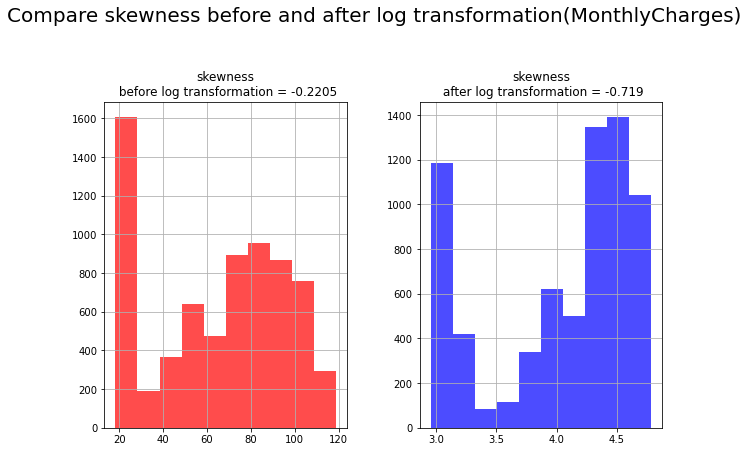

In [13]:
f, ax = plt.subplots(1, 2, figsize = (10, 6))
f.suptitle('Compare skewness before and after log transformation(MonthlyCharges)', y = 1.1, size = 20)
plt.subplots_adjust(wspace = .3)
data.MonthlyCharges.hist(color = 'r', ax = ax[0], alpha = .7)
np.log1p(data.MonthlyCharges).hist(color = 'b', alpha = .7)
ax[0].set_title(f'skewness\n before log transformation = {round(data.MonthlyCharges.skew(), 4)}')
ax[1].set_title(f'skewness\n after log transformation = {round(np.log1p(data.MonthlyCharges).skew(), 4)}')
plt.show()

The skewness has increased since log transformation. So, i did not log transformation.

TotalCharges column has 11 empty values. I did not drop those data because data should not be deleted arbitrarily.

In [14]:
data.loc[data.TotalCharges == ' '].shape[0]

11

So, i fill those values zero.

In [15]:
data.TotalCharges = data.TotalCharges.str.replace(' ', '0')
data.TotalCharges = data.TotalCharges.astype('float32')

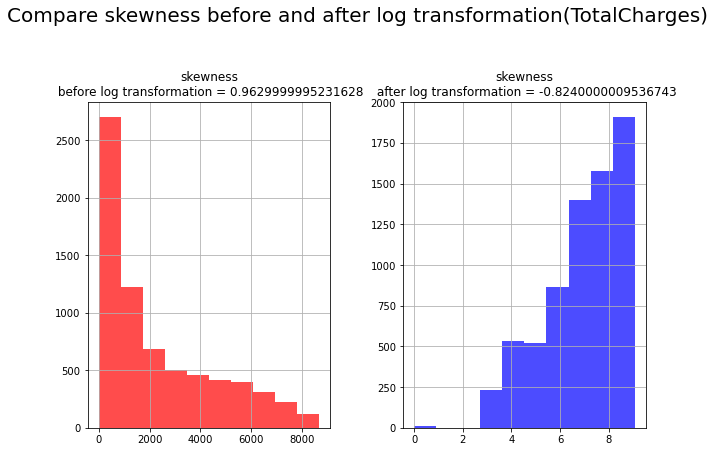

In [16]:
f, ax = plt.subplots(1, 2, figsize = (10, 6))
plt.subplots_adjust(wspace = .3)
f.suptitle('Compare skewness before and after log transformation(TotalCharges)', y = 1.1, size = 20)
data.TotalCharges.hist(color = 'r', ax = ax[0], alpha = .7)
np.log1p(data.TotalCharges).hist(color = 'b', alpha = .7, ax = ax[1])
ax[0].set_title(f'skewness\n before log transformation = {round(data.TotalCharges.skew(), 3)}')
ax[1].set_title(f'skewness\n after log transformation = {round(np.log1p(data.TotalCharges).skew(), 3)}')
plt.show()

In [17]:
def get_cnt_prob(col) :
    f, ax = plt.subplots(1, 2, figsize = (10, 5))
    f.suptitle(f'{col} & Churn', size = 20)
    plt.subplots_adjust(wspace = .5)
    ax[0].set_title(f'countplot({col})')
    ax[1].set_title(f'Target Probability Differences by {col}')
    ax[1].set_ylim(0, 0.5)
    sns.countplot(data[col], edgecolor = (0,0,0), palette = 'gist_rainbow', ax = ax[0])
    sns.pointplot(data[col], data.Churn, edgecolor = (0, 0, 0), palette = 'gist_rainbow', ax = ax[1])
    plt.show()

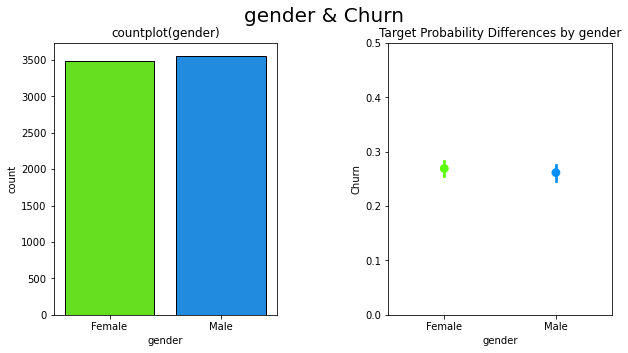

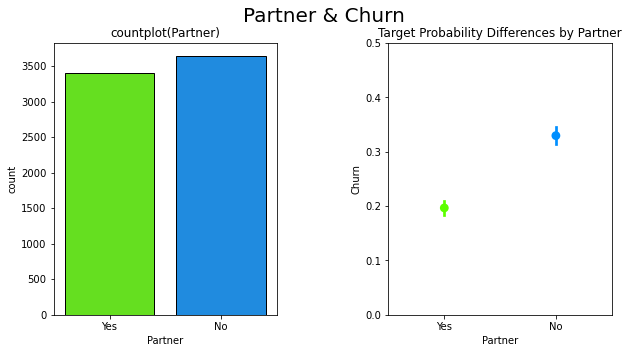

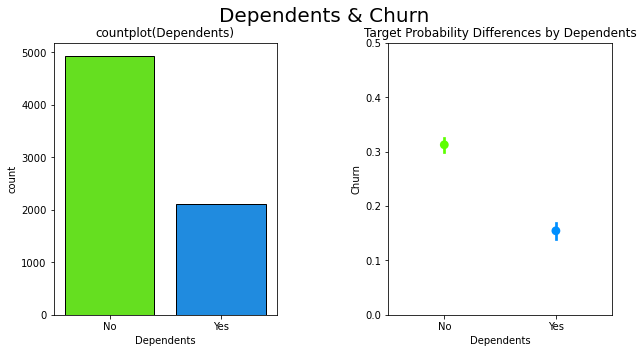

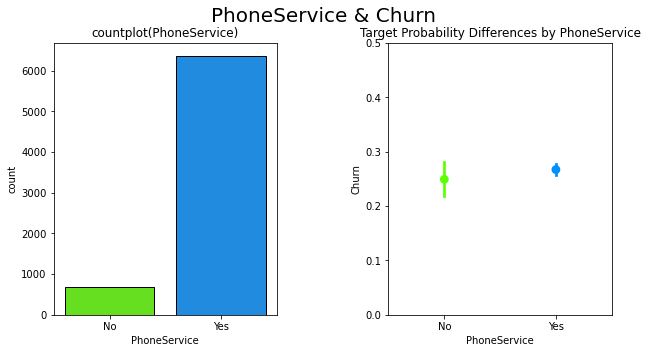

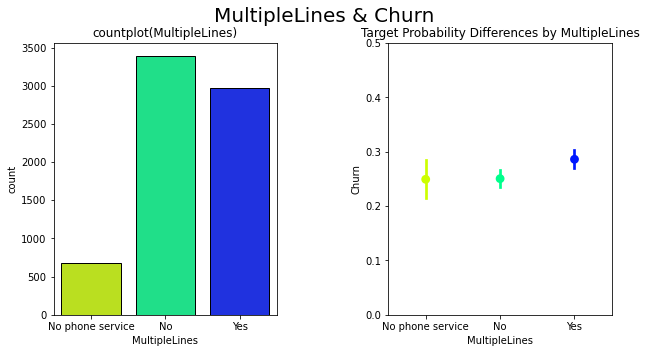

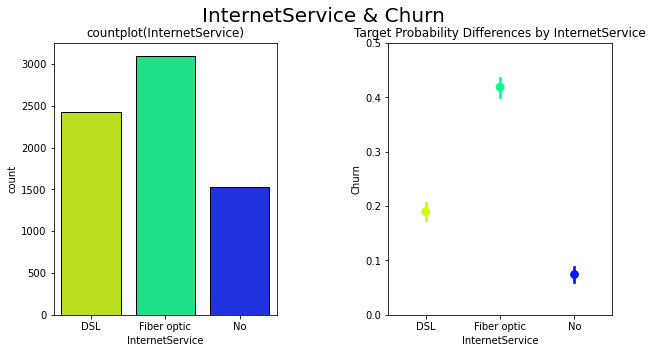

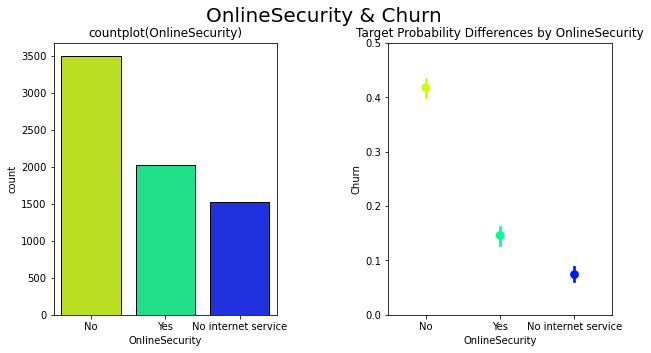

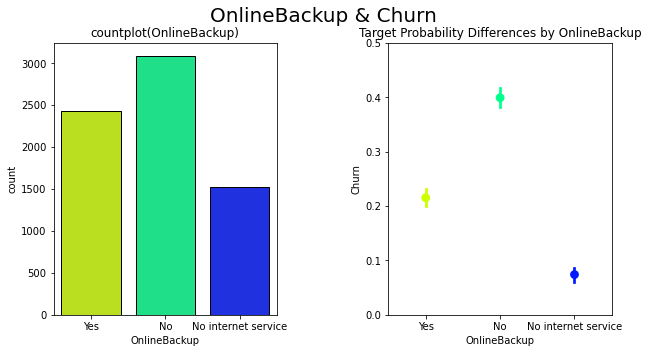

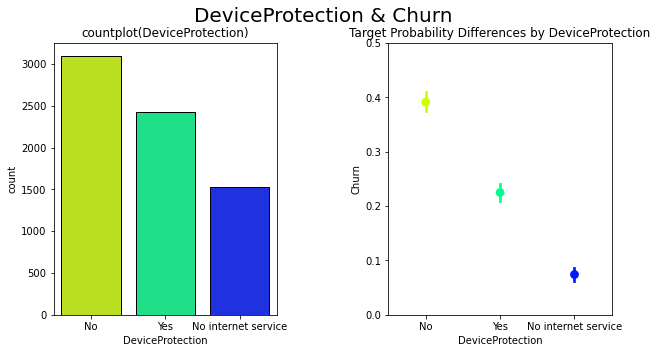

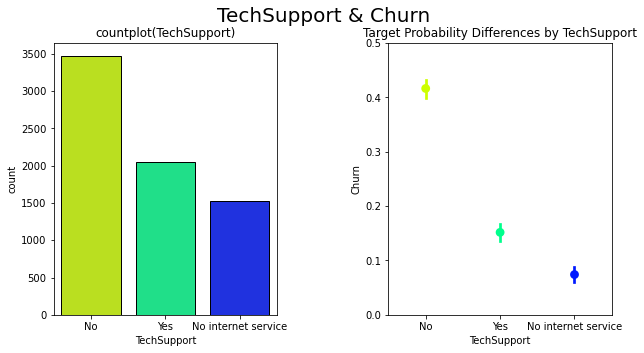

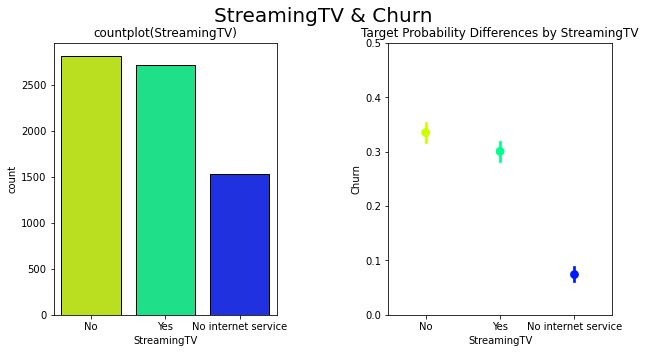

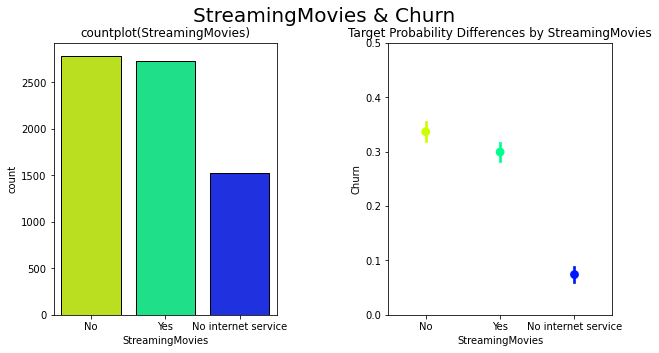

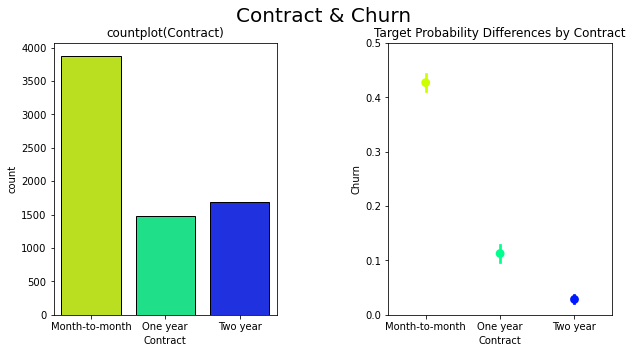

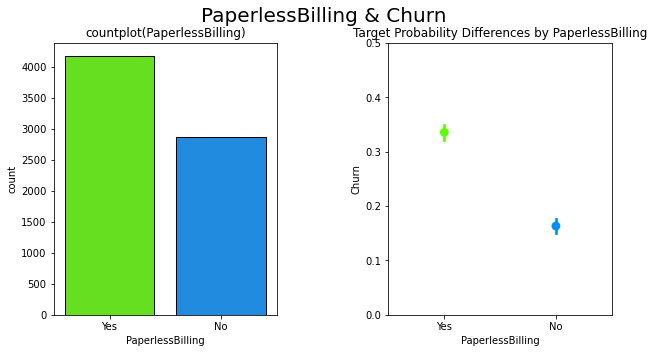

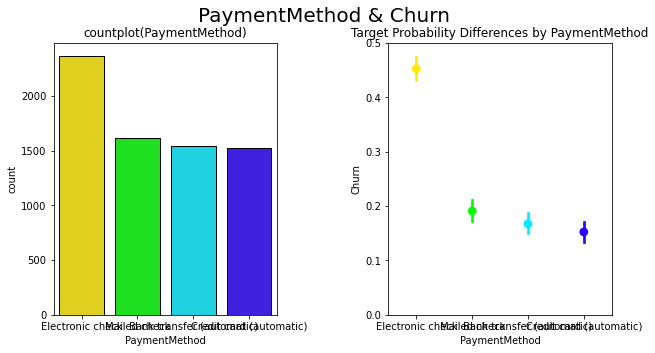

In [18]:
for c in obj_cols[:-2] :
    get_cnt_prob(c)

I found that no difference in probability values exists for each category in the two variables.

1. gender
2. PhoneService

In [19]:
data.drop(['gender', 'PhoneService'], axis = 1, inplace = True)

In [20]:
obj_cols = data.columns[data.dtypes == object]

I checked how many category values each categorical variable has.

Subsequently, categorical variables were divided into variables with three or more values and variables with two values.

In [21]:
over3 = [] # 3 or more than 3
val2 = [] # 2 values
for c in obj_cols :
    if data[c].nunique() > 2 :
        over3.append(c)
    else :
        val2.append(c)

In [22]:
over3

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [23]:
val2

['Partner', 'Dependents', 'PaperlessBilling']

About val2, I did LabelEncoding.

In [24]:
for c in val2 :
    lb = LabelEncoder()
    data[c] = lb.fit_transform(data[c])

About over3, I did one-hot encoding.

In [25]:
data = pd.get_dummies(columns = over3, data = data)

***

## Modeling

I used 6 models.

1. Gradientboosting
2. RandomForest
3. LGBM
4. XGB
5. Catboost
6. Voting with best 3 models

In [26]:
X = data.drop('Churn', axis = 1)
y = data.Churn

In [27]:
gb = GradientBoostingClassifier(random_state = 120)
rf = RandomForestClassifier(random_state = 120)
lgbm = LGBMClassifier(random_state = 120)
xgb = XGBClassifier(random_state = 120)
cb = CatBoostClassifier(random_state = 120, silent=True)

In [28]:
models = [gb, rf, lgbm, xgb, cb]

StratifiedKFold is better to classify data than other cv methods.

In [29]:
skf = StratifiedKFold(n_splits = 5, random_state = 120, shuffle = True)

In [30]:
model_acc = []

for model in models :
    acc_list = []
    roc_auc_list = []
    for i, (tr_idx, val_idx) in enumerate(skf.split(X, y)) :
        
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
        
        model.fit(tr_x, tr_y)
        pred = model.predict(val_x)
        acc = accuracy_score(val_y, pred)
        
        acc_list.append(acc)
    model_acc.append(np.mean(acc_list))

In [31]:
score_df = pd.DataFrame({'model' : [x.__class__.__name__ for x in models], 'accuracy' : model_acc}).sort_values(by = 'accuracy', ascending = False)

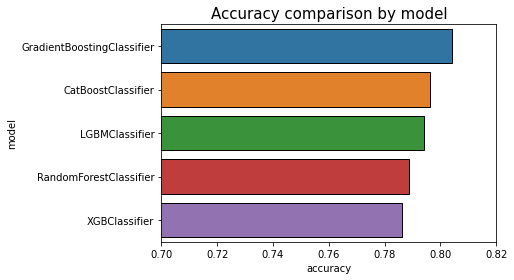

In [32]:
plt.title('Accuracy comparison by model', size = 15)
sns.barplot(y = score_df.model, x = score_df.accuracy, edgecolor = (0,0,0))
plt.xlim(.7, .82)
plt.show()

Except for one(GradientBoosting), all models have less than 0.8 accuracy.

In [33]:
vot = VotingClassifier(estimators = [('gb', gb), ('lgbm', lgbm), ('cb', cb)], weights = [.5, .2, .3])

In [34]:
vot_acc = []

for i, (tr_idx, val_idx) in enumerate(skf.split(X, y)) :
        
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]

    vot.fit(tr_x, tr_y)
    pred = vot.predict(val_x)
    acc = accuracy_score(val_y, pred)

    vot_acc.append(acc)

In [35]:
print(f'accuracy of VotingClassfier = {np.mean(vot_acc)}')

accuracy of VotingClassfier = 0.8029244830311633


The accuracy of the model exceeded 0.8.

## Finished. Thanks for watching this notebook!

## Have a nice work.